Grup 2 (Pierre Clavier)

María Magdalena Sánchez del Río Aufrere de la Preugne

# <center> TP 4: Improve the Metropolis-Hastings Algorithm
    

##  Exercise 1: Adaptative Metropolis-Hastings withim Gibbs Sampler

### 1-A Metropolis-Hastings within Gibss Samples

#### Question 1. Implementation

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm
from scipy.stats import multivariate_normal
import random
from scipy.stats import invgamma

In [2]:
def objective_func(x,y,a):
    '''
    Target Distribution of exercise 1.
    '''
    # Compute log of the objective function
    log_o = -(x**2/a**2)-y**2-(1/4)*(x**2/a**2-y**2)**2 
    
    return np.exp(log_o)

In [3]:
def MH_P1(x0,y,a,maxIter=1, burnIn = 1000, sigma_prop = 0.01):
    '''
    Symmetric Random Walk Metropolis Hastings for the first component of the proposed distribution.
    
    :return chain: array with sample
    :return acc_ratio: acceptance ratio after burnin period 
    '''
    chain = np.asarray([x0])
    acc = 0 #Number of accepted movemetns after burn-in period
    
    for i in range(maxIter+burnIn):
        u = np.random.rand()
        
        # Proposed next step of the chain
        x_prop = np.random.normal(chain[-1],sigma_prop)
        
        # Acceptance probability
        alpha = objective_func(x_prop,y,a)/objective_func(chain[-1],y,a)
        
        # Accept the movement w.p. alpha, stay in place w.p. 1-alpha
        if u>alpha:
            x_prop = chain[-1]
        else: 
            if i>=burnIn: acc +=1 #Update number of accepted movements if accepted and burin period elapsed

        chain = np.append(chain,[x_prop])
        acc_ratio = acc/(maxIter)
        
    return chain[burnIn+1: ], acc_ratio
        

In [4]:
def MH_P2(x,y0,a,maxIter=1, burnIn = 1000, sigma_prop = 0.01):
    '''
    Symmetric Random Walk Metropolis Hastings for the second component of the proposed distribution.
    
    :return chain: array with sample
    :return acc_ratio: acceptance ratio after burnin period 
    '''
    chain = np.asarray([y0])
    acc = 0 #Number of accepted movemetns after burn-in period
        
    for i in range(maxIter+burnIn):
        u = np.random.rand()
        
        # Proposed next step of the chain
        y_prop = np.random.normal(chain[-1],sigma_prop)

        # Acceptance probability
        alpha = objective_func(x,y_prop,a)/ objective_func(x,chain[-1],a)
        
        # Accept the movement w.p. alpha, stay in place w.p. 1-alpha 
        # Update number of accepted movements if applies
        if u>alpha:
            y_prop = chain[-1]
        else: 
            if i>=burnIn: acc +=1
            
        chain = np.append(chain,[y_prop])
        acc_ratio = acc/(maxIter)
        
    return chain[burnIn+1: ], acc_ratio

In [5]:
def MH_within_Gibbs(z0, sampleSize, a = 10, sig1 = 3, sig2 = 3, burnMH = 0):
    '''
    Metropolis Hastings within Gibbs sampler for the distribution with density pi from ex. 1A.
    
    :return chain: array with sample
    :return acceptance_x: average acceptance ratios in the metropolis hastings iterations for component x 
    :return acceptance_y: average acceptance ratios in the metropolis hastings iterations for component y
    '''
    sample = np.asarray([z0])
    
    # Lists of acceptance rates for each iteration of Metropolis Hastings
    acc_x = np.zeros([sampleSize])
    acc_y = np.zeros([sampleSize])
    
    for i in tqdm(range(sampleSize)):
        z = sample[-1]
        
        #Sample x
        z[0], acc_x[i] =  MH_P1(z[0],z[1],a,burnIn=burnMH,sigma_prop=sig1)
        
        #Sample y
        z[1], acc_y[i] = MH_P2(z[0],z[1],a,burnIn=burnMH,sigma_prop=sig2)
                
        sample = np.append(sample, [z], axis=0)
        
    #Average acceptance rates for each component
    acceptance_x =  acc_x.sum()/sampleSize
    acceptance_y =  acc_y.sum()/sampleSize
        
    return sample,  acceptance_x,  acceptance_y

#### Question 2. Results

In [6]:
sample, x_rate, y_rate = MH_within_Gibbs(np.asarray([0.,0.]),10000 )

100%|██████████| 10000/10000 [00:00<00:00, 27102.83it/s]


Mean acceptance ratio for the first component:  0.8669
Mean acceptance ratio for the second component:  0.2578


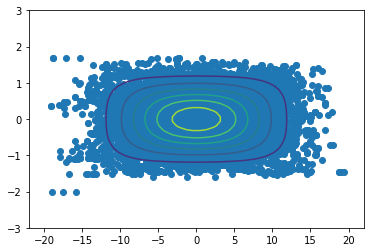

In [7]:
print('Mean acceptance ratio for the first component: ', x_rate)
print('Mean acceptance ratio for the second component: ', y_rate)

x = np.linspace(-22, 22, 50)
y = np.linspace(-3, 3, 50)

X, Y = np.meshgrid(x, y)
plt.contour(X,Y, objective_func(X, Y,10));

plt.scatter(sample[:,0],sample[:,1] , label = '')
plt.show()

Figure(432x288)
Figure(432x288)


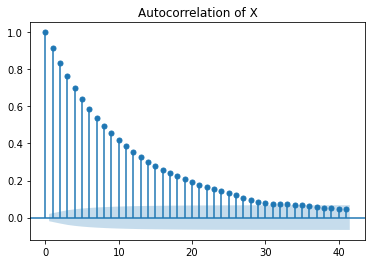

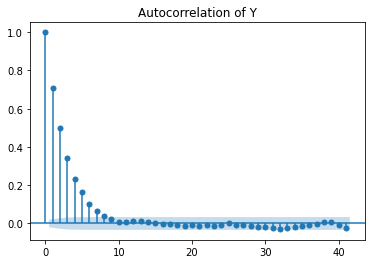

In [8]:

print(plot_acf(sample[:,0], title = 'Autocorrelation of X'))
print(plot_acf(sample[:,1], title = 'Autocorrelation of Y'))


We can observe that sampled values seem tend to appear aligned parallel to the horizontal axis. This means that the  stochastic process resulting from HM tends to get stuck along the x-axis for several consecutive states. In turn, this implies that we are probably not obtaining independent samples.

This is confirmed by the autocorrelation plots above. If our sample was i.i.d. we would obtain values much closer to zero. We see that autocorrelation values are specially larger for the x-axis.

On the other hand, we observe that the mean acceptance ratio for the first component of our sample is 0.864, which is higher than the optimal one, 0.234. This means that, while values for $x$ change in most states of the Markov Chain, $y$ will stay the same for a few states before accepting a new value. This results in subsequences in the markov chain with the same value for y, but different values of y, i.e., horizontal lines. 

#### Question 3. Possible Improvements

The first possible solution is, as we will review in the following exercises, using an Adaptative version of our algorithm, making sure we stick to the optimal acceptance ratio, by changing the variance of the proposition distribution.

A different possible solution is to increase the burn-in time in the Metropolis-Hastings algorithms, since this would ensure we reach the more "ergodic" stage of the chain, so that our samples become independent. We proceed to experiment this alternative solution.

In [9]:
sample2, x_rate2, y_rate2 = MH_within_Gibbs(np.asarray([0.,0.]),10000, burnMH = 1000 )


100%|██████████| 10000/10000 [04:32<00:00, 36.66it/s]


0.8557
0.2503


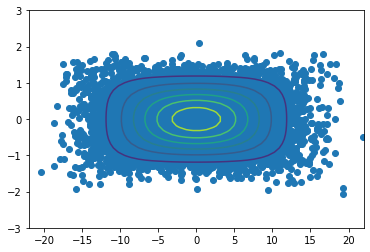

In [10]:
plt.contour(X,Y, objective_func(X, Y,10));
plt.scatter(sample2[:,0],sample2[:,1] , label = '')
print(x_rate2)
print(y_rate2)
plt.show()

Figure(432x288)
Figure(432x288)


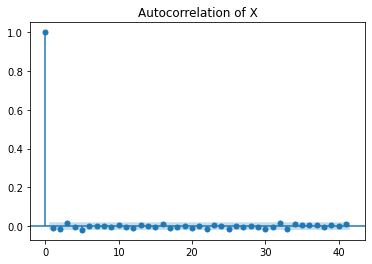

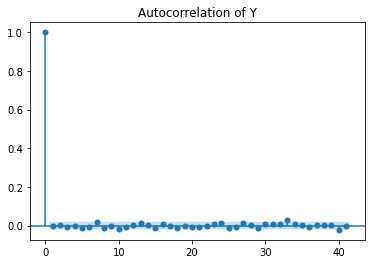

In [11]:
print(plot_acf(sample2[:,0], title = 'Autocorrelation of X'))
print(plot_acf(sample2[:,1], title = 'Autocorrelation of Y'))

We observe that, while we have achieved more independent samples, the acceptance rate for the x axis is still far from the optimal value. To achieve a lower acceptance ratio in such component, we could just chose a grater variance. It would make sense, since we get a good acceptance ratio in the y-axis, to use a proportional variance in the x-axis, with respect to the range of values taken by the distribution.

100%|██████████| 10000/10000 [04:35<00:00, 36.35it/s]


Mean acceptance ratio for the first component:  0.2601
Mean acceptance ratio for the second component:  0.2651


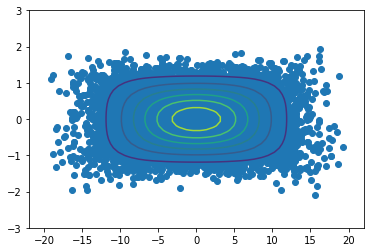

In [12]:
sample3, x_rate3, y_rate3 = MH_within_Gibbs(np.asarray([0.,0.]),10000, burnMH = 1000,sig1 = 30 )
print('Mean acceptance ratio for the first component: ', x_rate3)
print('Mean acceptance ratio for the second component: ', y_rate3)

plt.contour(X,Y, objective_func(X, Y,10));
plt.scatter(sample3[:,0],sample3[:,1] , label = '')
plt.show()

We have now obtained very similar acceptance ratios in both axis. It makes sense since we have used proportional variances with respect to the ranges, and because the distribution has a scaled symetry, in the sense that the behavior is the same with respect to x and y, buy reaches higher values for x.

### 1.B - Adaptative Metropolis-Hastings within Gibbs Sampler 

#### Question 1. Adaptative MHwG for Density $\pi$

In [13]:
def adaptative_MHwG(z0, sampleSize, a = 10, sig1 = 3, sig2 = 3, burnMH = 0):
    sample = np.asarray([z0])
    acc_x = np.zeros([sampleSize])
    acc_y = np.zeros([sampleSize])
    l = np.asarray([np.log(sig1), np.log(sig2)])
    
    for i in tqdm(range(sampleSize)):
        z = sample[-1]
        
        if (i+1)%50==0:
            delta1 = min(0.01, (i+1)**(-1/2))
            delta2 = min(0.01, (i+1)**(-1/2))
            if acc_x.sum()/i<0.24: delta1 = -delta1
            if acc_y.sum()/i<0.24: delta2 = -delta2
            l[0] += delta1
            l[1] += delta2
        
        z[0], acc_x[i] =  MH_P1(z[0],z[1],a,burnIn=burnMH,sigma_prop=np.exp(l[0]))
        
        z[1], acc_y[i] = MH_P2(z[0],z[1],a,burnIn=burnMH,sigma_prop=np.exp(l[1]))
                
        sample = np.append(sample, [z], axis=0)
        
    acceptance_x =  acc_x.sum()/sampleSize
    acceptance_y =  acc_y.sum()/sampleSize
        
    return sample,  acceptance_x,  acceptance_y

In [14]:
sample_ad, x_rate_ad, y_rate_ad =adaptative_MHwG(np.asarray([0.,0.]),10000 )


100%|██████████| 10000/10000 [00:00<00:00, 23305.79it/s]


Mean acceptance ratio for the first component:  0.6342
Mean acceptance ratio for the second component:  0.2356


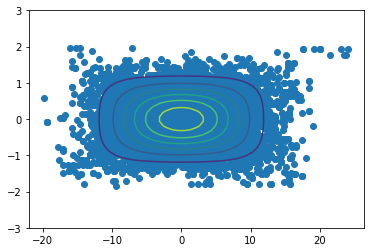

In [15]:

print('Mean acceptance ratio for the first component: ', x_rate_ad)
print('Mean acceptance ratio for the second component: ', y_rate_ad)

x = np.linspace(-22, 22, 50)
y = np.linspace(-3, 3, 50)

X, Y = np.meshgrid(x, y)
plt.contour(X,Y, objective_func(X, Y,10));

plt.scatter(sample_ad[:,0],sample_ad[:,1] , label = '')
plt.show()

Figure(432x288)
Figure(432x288)


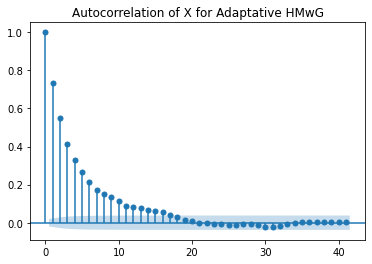

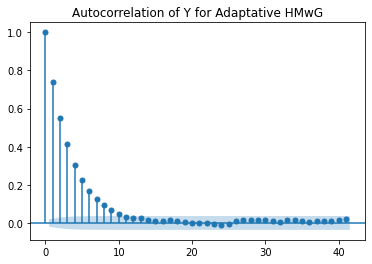

In [16]:

print(plot_acf(sample_ad[:,0], title = 'Autocorrelation of X for Adaptative HMwG'))
print(plot_acf(sample_ad[:,1], title = 'Autocorrelation of Y for Adaptative HMwG'))


We can see that the autocorrelation values have improved with respect to the non-adaptative algorithm for no burn-in time in the metropolis-hasting samplings, so that the last samples are a better approximation of i.i.d. samples. If we also implemented one of the solutions proposed in question 3, from exercise 1.b, such as initializing the variance for the x-axis with a higher value we could get even better results. Indeed, in the following plots we can see that initializing the variance for x to 30 allows to reach the "ergodic" state of the chain faster.

100%|██████████| 10000/10000 [00:00<00:00, 23341.03it/s]


Mean acceptance ratio for the first component:  0.241
Mean acceptance ratio for the second component:  0.2442


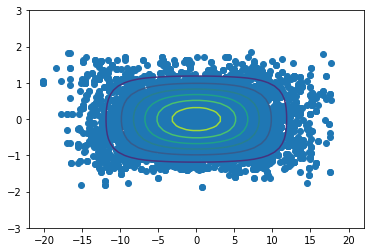

Figure(432x288)
Figure(432x288)


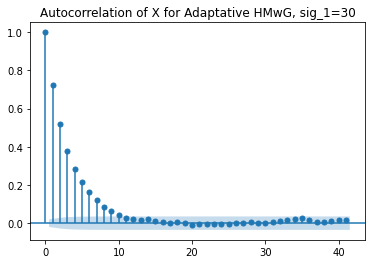

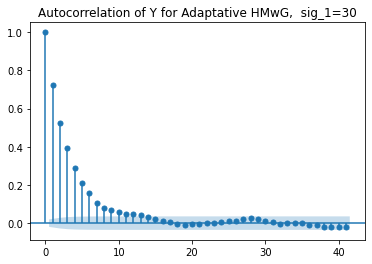

In [18]:
sample_ad, x_rate_ad, y_rate_ad =adaptative_MHwG(np.asarray([0.,0.]),10000, sig1 = 30 )

print('Mean acceptance ratio for the first component: ', x_rate_ad)
print('Mean acceptance ratio for the second component: ', y_rate_ad)

x = np.linspace(-22, 22, 50)
y = np.linspace(-3, 3, 50)

X, Y = np.meshgrid(x, y)
plt.contour(X,Y, objective_func(X, Y,10));

plt.scatter(sample_ad[:,0],sample_ad[:,1] , label = '')
plt.show()


print(plot_acf(sample_ad[:,0], title = 'Autocorrelation of X for Adaptative HMwG, sig_1=30'))
print(plot_acf(sample_ad[:,1], title = 'Autocorrelation of Y for Adaptative HMwG,  sig_1=30'))

#### Question 2. Adaptative HMwG for the Gaussian and the Banana Shape Distribution



_Adaptative VS Non-Adaptative Metropolis-Hastings withn Gibbs, for a Multivariate Gaussian Distribution_

As in 1.A we can see that the differences in acceptace rates makes the stochastic process get stuck in lines parallel to the x.axis in the non-adaptative algorithm, and the adaptative algorithm achieves better results.

In [19]:
file_matrix = open("tmalaexcov.txt", "r")
  
sigma = np.loadtxt(file_matrix, dtype=float)
              
file_matrix.close()

In [24]:
def MHwG_Gauss(z0, sampleSize,sigma_prop, d=20):
    '''
    Metropolis Hastings within Gibbs sampler for the distribution with density pi from ex. 
    We do Metropolis Hastings with one iteration (no burn in).
    
    '''
    sample = np.asarray([z0])
    acc = np.zeros(d)
    target = multivariate_normal(mean = np.zeros(20), cov = sigma)

    
    # Lists of acceptance rates for each iteration of Metropolis Hastings
    #accepted = np.zeros((d,sampleSize))
    
    for i in tqdm(range(sampleSize)):
        z = sample[-1].copy()
        
        for j in range(d):
            u = np.random.rand()

            z[j] = np.random.normal(sample[-1,j],sigma_prop)

            # Acceptance probability
            alpha = target.pdf(z)/target.pdf(sample[-1])

            # Accept the movement w.p. alpha, stay in place w.p. 1-alpha 
            if u>alpha:
                z[j] = sample[-1,j]
            else: acc[j]+=1

        sample = np.append(sample, [z], axis=0)        

    return sample, acc/(sampleSize)

100%|██████████| 10000/10000 [00:06<00:00, 1659.39it/s]

Acceptance rates [0.1943 0.1664 0.2107 0.1859 0.2513 0.2202 0.1968 0.1934 0.2412 0.2611
 0.199  0.207  0.1873 0.1618 0.2241 0.2572 0.2175 0.2307 0.1531 0.1536]
Average acceptance rate 0.20562999999999998


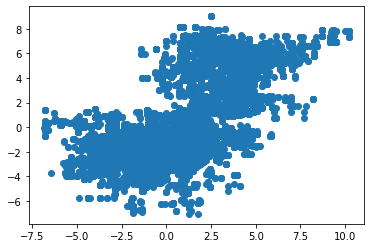

In [25]:
sample_Gauss ,acc_rates = MHwG_Gauss(np.zeros(20), 10000 ,sigma_prop = 3)
print('Acceptance rates', acc_rates)
print('Average acceptance rate', acc_rates.sum()/20)
plt.scatter(sample_Gauss[:,0],sample_Gauss[:,1], label = '')

In [26]:
def MHwG_Gauss_adapt(z0, sampleSize, d=20):
    '''
    Metropolis Hastings within Gibbs sampler for the distribution with density pi from ex. 
    We do Metropolis Hastings with one iteration (no burn in).
    
    '''
    sample = np.asarray([z0])
    acc = np.zeros(20)
    l = np.zeros(20)
    target = multivariate_normal(mean = np.zeros(20), cov = sigma)
    
    # Lists of acceptance rates for each iteration of Metropolis Hastings
    #accepted = np.zeros((d,sampleSize))
        
    for i in tqdm(range(sampleSize)):
        z = sample[-1].copy()
        
        for j in range(d):
            
            if (i+1)%50==0:
                delta = min(0.01, (i+1)**(-1/2))
                if acc[j]/i<0.24: delta = -delta
                l[j] += delta
            
            u = np.random.rand()
          
            z[j] = np.random.normal(sample[-1,j],np.exp(l[j]))

            # Acceptance probability
            alpha = target.pdf(z)/target.pdf(sample[-1])

            # Accept the movement w.p. alpha, stay in place w.p. 1-alpha 
            if u>alpha:
                z[j] = sample[-1,j]
            else: acc[j] +=1
             

        sample = np.append(sample, [z], axis=0)        
        
    return sample, acc/sampleSize


100%|██████████| 50000/50000 [00:37<00:00, 1332.01it/s]

Acceptace rates [0.23878 0.23578 0.22222 0.22694 0.24734 0.22486 0.22582 0.24268 0.23446
 0.2456  0.23338 0.237   0.24268 0.2412  0.22362 0.26364 0.22494 0.22322
 0.23632 0.23064]


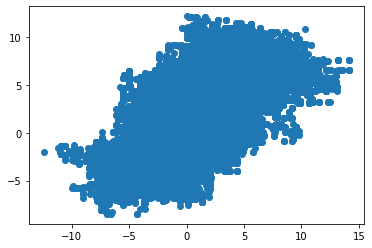

In [27]:
sample_Gauss2, acceptances = MHwG_Gauss_adapt(np.zeros(20), 50000 )
print('Acceptace rates', acceptances)
plt.scatter(sample_Gauss2[:,0],sample_Gauss2[:,1], label = '')

_Adaptative VS Non-Adaptative Metropolis-Hastings withn Gibbs, for the Banana-Shape Dsitribution_

In this case we de not see such a big difference, at least at first glance, since the acceptance rate is quite similar for each component in the non-adaptative algorithm. However, since in the adaptative one we achieve acceptance rates closer to the optimal rate, it is theoretically better.

In [28]:
def banana(x, B=0.1):
    '''
    
    '''
    # Compute log of the objective function
    log_banana = -(x[0]**2)/200. - 0.5*(x[1]+B*x[0]**2-100*B)**2 - 0.5*sum(x[2:]**2)
     
    return np.exp(log_banana)

In [35]:
def MHwG_banana(z0, sampleSize,sigma_prop, d=20):
    '''
    Metropolis Hastings within Gibbs sampler for the distribution with density pi from ex. 
    We do Metropolis Hastings with one iteration (no burn in).
    
    '''
    sample = np.asarray([z0])
    acc = np.zeros(d)
    
    # Lists of acceptance rates for each iteration of Metropolis Hastings
    #accepted = np.zeros((d,sampleSize))
    
    for i in tqdm(range(sampleSize)):
        z = sample[-1].copy()
        
        for j in range(d):
            u = np.random.rand()

            z[j] = np.random.normal(sample[-1,j],sigma_prop)

            # Acceptance probability
            alpha = banana(z)/banana(sample[-1])

            # Accept the movement w.p. alpha, stay in place w.p. 1-alpha 
            if u>alpha:
                z[j] = sample[-1,j]
            else: acc[j]+=1

        sample = np.append(sample, [z], axis=0)        

        
    return sample, acc/(sampleSize)

100%|██████████| 100000/100000 [01:05<00:00, 1531.89it/s]


Acceptance rates [0.33727 0.33318 0.32538 0.32803 0.3275  0.32753 0.3246  0.32455 0.32593
 0.32309 0.324   0.32588 0.32478 0.32398 0.32232 0.32339 0.32251 0.32135
 0.3243  0.3219 ]
Average acceptance rate 0.32557350000000007


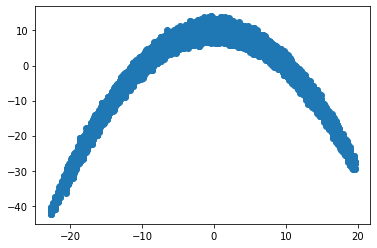

In [37]:
init = np.zeros(20)
init[1]=10
sample_banana ,acc_rate = MHwG_banana(init, 100000 ,sigma_prop = 3.5)
print('Acceptance rates', acc_rate)
print('Average acceptance rate', acc_rate.sum()/20)
plt.scatter(sample_banana[:,0],sample_banana[:,1], label = '')

In [43]:
def MHwG_banana_adapt(z0, sampleSize, d=20):
    '''
    Metropolis Hastings within Gibbs sampler for the distribution with density pi from ex. 
    We do Metropolis Hastings with one iteration (no burn in).
    
    '''
    sample = np.asarray([z0])
    acc = np.zeros(20)
    l = np.ones(20)*1.25
    
    # Lists of acceptance rates for each iteration of Metropolis Hastings
    #accepted = np.zeros((d,sampleSize))
        
    for i in tqdm(range(sampleSize)):
        z = sample[-1].copy()
        
        for j in range(d):
            
            if (i+1)%50==0:
                delta = min(0.01, (i+1)**(-1/2))
                if acc[j]/i<0.24: delta = -delta
                l[j] += delta
            
            u = np.random.rand()
          
            z[j] = np.random.normal(sample[-1,j],np.exp(l[j]))

            # Acceptance probability
            alpha = banana(z)/banana(sample[-1])

            # Accept the movement w.p. alpha, stay in place w.p. 1-alpha 
            if u>alpha:
                z[j] = sample[-1,j]
            else: acc[j] +=1
             

        sample = np.append(sample, [z], axis=0)        
        
    return sample, acc/sampleSize


In [46]:
sample_banana2, acc_rates = MHwG_banana_adapt(init, 100000 )

100%|██████████| 100000/100000 [01:08<00:00, 1456.75it/s]


Acceptance rate per component [0.25342 0.2423  0.24184 0.23858 0.2405  0.23821 0.23929 0.24121 0.24068
 0.24005 0.24056 0.241   0.24025 0.23837 0.23833 0.23932 0.23743 0.24266
 0.24102 0.24056]
Average acceptance rate 0.240779


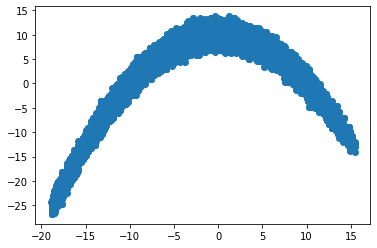

In [47]:
print('Acceptance rate per component', acc_rates)
print('Average acceptance rate', acc_rates.sum()/20)
plt.scatter(sample_banana2[:,0],sample_banana2[:,1], label = '')

##  Exercise 2: from Sampling Multimodal Distributions

### 2.A - A Toy Example

#### Question 1. Implementation

In [48]:
mu = np.asarray([[2.18, 5.76], 
         [8.67, 9.59],
         [4.24, 8.48],
         [8.41, 1.68],
         [3.93, 8.82],
         [3.25, 3.47],
         [1.70,0.50],
         [4.59, 5.60],
         [6.91, 5.81],
         [6.87, 5.40],
         [5.41, 2.65],
         [2.70, 7.88],
         [4.98,3.70],
         [1.14,2.39],
         [8.33,9.50],
         [4.93,1.50],
         [1.83,0.09],
         [2.26,0.31],
         [5.54,6.86],
         [1.69,8.11]])

In [49]:
def target_GMM (x):
    '''
    Distribution of the GMM model as described in exercise 2.
    '''
    density = 0
    sig = 0.1
    w = 0.05
    
    for i in range(20):
        expon = -1/(2*sig**2)*np.dot((x-mu[i]).T,x-mu[i])
        density += w/(2*np.pi*sig**2)*np.exp(expon)
        
    return density

In [50]:
def MH_GMM(x0,maxIter=1, burnIn = 1000, sigma_prop = 0.01*np.eye(2)):
    '''
    Symmetric Random Walk Metropolis Hastings for the proposed distribution.
    
    :return chain: array with sample
    :return acc_ratio: acceptance ratio after burnin period 
    '''
    chain = np.asarray([x0])
    acc = 0 #Number of accepted movemetns after burn-in period
        
    for i in range(maxIter+burnIn):
        u = np.random.rand()
    
        x = chain[-1]

        
        # Proposed next step of the chain
        x_prop = np.random.multivariate_normal(x,sigma_prop)

        # Acceptance probability
        alpha = target_GMM(x_prop)/target_GMM(x)
        
        # Accept the movement w.p. alpha, stay in place w.p. 1-alpha 
        # Update number of accepted movements if applies
        if u>alpha:
            x_prop = x
        else: 
            if i>=maxIter-1: acc +=1
            
        chain = np.append(chain,[x_prop], axis = 0)
    
    acc_ratio = acc/(maxIter+burnIn)
        
    return chain[burnIn+1: ], acc_ratio

Acceptace Ratio in Standard Metropolis Hastings:  0.05381818181818182


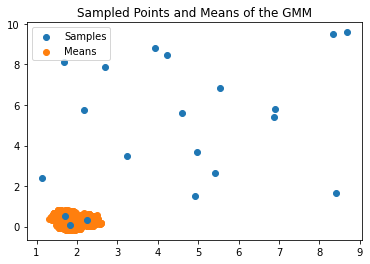

In [51]:
sample_GMM, acceptance_ratio = MH_GMM(np.zeros(2), maxIter = 10000)
print('Acceptace Ratio in Standard Metropolis Hastings: ', acceptance_ratio)
plt.scatter(mu[:,0],mu[:,1],zorder = 2, label = 'Samples')
plt.scatter(sample_GMM[:,0], sample_GMM[:,1], zorder = 1, label = 'Means')
plt.title('Sampled Points and Means of the GMM')
plt.legend()
plt.show()

In [52]:
def adaptative_MH_GMM(x0, maxIter, sigma_prop = 0.01*np.eye(2), burnIn = 0):
    sample = np.asarray([x0])
    l = 0
    acc = 0 #Number of accepted movemetns after burn-in period
    
    for i in tqdm(range(maxIter+burnIn)):
        u = np.random.rand()
        x = sample[-1]
        
        #Update variance of proposition distribution
        if (i+1)%50==0:
            delta = min(0.01, (i+1)**(-1/2))
            if acc/i<0.24: delta = -delta
            sigma_prop += delta*np.eye(2)

        # Proposed next step of the chain
        x_prop = np.random.multivariate_normal(x,sigma_prop)

        # Acceptance probability
        alpha = target_GMM(x_prop)/target_GMM(x)
        
        # Accept the movement w.p. alpha, stay in place w.p. 1-alpha 
        # Update number of accepted movements if applies
        if u>alpha:
            x_prop = x
        else: 
            if i>=maxIter-1: acc +=1
            
        sample = np.append(sample,[x_prop], axis = 0)
        
    acceptance =  acc/maxIter
    
    return sample,  acceptance

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-52-8b4b87b9fb0b>:17: RuntimeWarning: covariance is not positive-semidefinite.
  x_prop = np.random.multivariate_normal(x,sigma_prop)
100%|██████████| 10000/10000 [00:02<00:00, 4836.01it/s]


Acceptace Ratio in Standard Metropolis Hastings:  0.0001


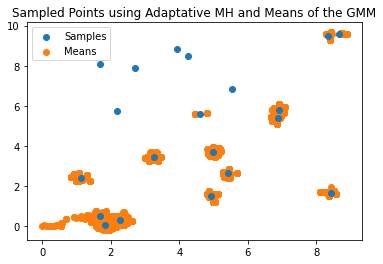

In [53]:
sample_GMM_adap, acceptance_ratio_adap = adaptative_MH_GMM(np.zeros(2), maxIter = 10000)
print('Acceptace Ratio in Standard Metropolis Hastings: ', acceptance_ratio_adap)
plt.scatter(mu[:,0],mu[:,1],zorder = 2, label = 'Samples')
plt.scatter(sample_GMM_adap[:,0], sample_GMM_adap[:,1], zorder = 1, label = 'Means')
plt.title('Sampled Points using Adaptative MH and Means of the GMM')
plt.legend()
plt.show()

#### Question 2. Results

We observe in the plots above that, in the non-adaptative algorithm, we are only able to sample from the gaussians closer to the initial state of the chain. While the adaptative method is able to sample from more gaussians than the non-adaptative one, it fails to sample from some of them and tends to sample more points from the gaussians that are closer to the initial states of the chain. Moreover, the acceptance rate is very low.

We also observe in the following plot, that, adding a burn-in period, helps a bit to sample more from gaussians that are further from the initial points. This happens because, the ergodic properties of the chain that results from a MH algorithm, allows the chain to forget where it started. However, it has a very low acceptance ratio, and this can be seen in the plot below, as there are not many points (they are actually on on top of the other as the chain stays in the same point for many consecutive states).

  0%|          | 0/11000 [00:00<?, ?it/s]<ipython-input-52-8b4b87b9fb0b>:17: RuntimeWarning: covariance is not positive-semidefinite.
  x_prop = np.random.multivariate_normal(x,sigma_prop)
100%|██████████| 11000/11000 [00:02<00:00, 4876.07it/s]

Acceptace Ratio in Standard Metropolis Hastings:  0.0017


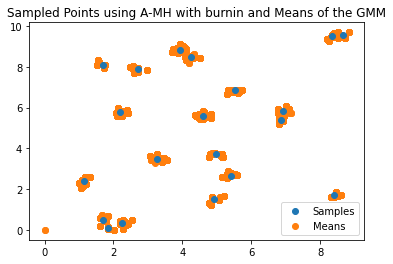

In [57]:
sample_GMM_adap, acceptance_ratio_adap = adaptative_MH_GMM(np.zeros(2), maxIter = 10000,burnIn = 1000)
print('Acceptace Ratio in Standard Metropolis Hastings: ', acceptance_ratio_adap)
plt.scatter(mu[:,0],mu[:,1],zorder = 2, label = 'Samples')
plt.scatter(sample_GMM_adap[:,0], sample_GMM_adap[:,1], zorder = 1, label = 'Means')
plt.title('Sampled Points using A-MH with burnin and Means of the GMM')
plt.legend()

### 2.B-Parallel Tempering

#### Question 1. Implementation

In [62]:
def parallel_tempering(x0, maxIters, T = [60, 21.6, 7.7,3.8,1], sigma_prop = np.eye(2), burnIn = 0):
    '''
    Parallel Tempering Metropolis Hastings Algorithm  for a Gaussian Mixture Model.
    '''
    K = len(T)
    x = np.zeros((K, maxIters+burnIn,2))
    x[:,0] = [x0]*K
    tau = 0.25*np.sqrt(T)

    for i in range(1,maxIters):

        #Draw new states for each of the temperatures
        for j in range(K):
            u = np.random.rand()
            x_prev = x[j,i-1]

            # Proposed next step of the chain   
            x_prop = np.random.multivariate_normal(x_prev,(tau[j]**2)*sigma_prop)
           
            # Acceptance probability
            alpha = (target_GMM(x_prop)/target_GMM(x_prev))**(1./T[j])

            # Accept the movement w.p. alpha, stay in place w.p. 1-alpha 
            # Update number of accepted movements if applies
            if u>alpha:
                x_prop = x_prev
                
            x[j,i] = x_prop

        #Chose random pair of consecutive temperatures 
        possible_com = [[k,k+1] for k in range(K-1)]
        swap = random.choice(possible_com)
        k = swap[0]
        j = swap[1]

        #Compute probability
        swap_prob = (target_GMM(x[j,i])**(1./T[k])*target_GMM(x[k,i])**(1./T[j]))/(target_GMM(x[k,i])**(1./T[k])*target_GMM(x[j,i])**(1./T[j]))
        
        v = np.random.rand()
        
        #Swap with probability swap_prob
        if v <= swap_prob:
            aux = x[j,i]
            x[j,i] = x[k,i]
            x[k,i] = aux
                
    return x
    

#### Question 2.Results

In [65]:
sample_PT = parallel_tempering(np.asarray([0,0]), 10000)

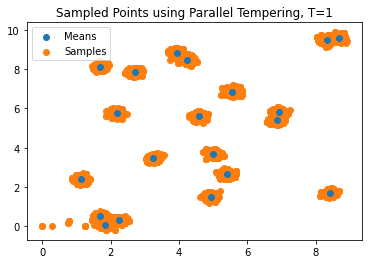

In [66]:
# Resulting chain for the target distribution (temperature 1)
plt.scatter(mu[:,0],mu[:,1],zorder = 2, label = 'Means')
plt.scatter(sample_PT[5-1,:,0], sample_PT[5-1,:,1], zorder = 1, label = 'Samples')
plt.title('Sampled Points using Parallel Tempering, T=1')
plt.legend()
plt.show()

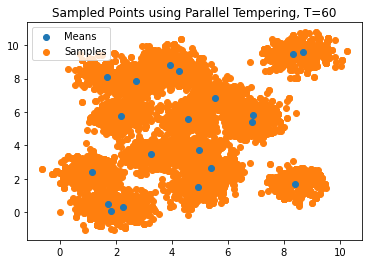

In [67]:
# Resulting Chain for the highest temperature
plt.scatter(mu[:,0],mu[:,1],zorder = 2, label = 'Means')
plt.scatter(sample_PT[1,:,0], sample_PT[1,:,1], zorder = 1, label = 'Samples')
plt.title('Sampled Points using Parallel Tempering, T=60')
plt.legend()
plt.show()

**Discussion of the Results.** We clearly achieved a much better sample using Parallel Tempering, as we can see that the resulting sample reaches all gaussians and has points uniformly distributed in all of them. The unlikely points in the bottom left corner are the result of initializing the algorithm in a point with very low probability according to the target distribution.

## Exercise 3: Bayesian Analysis of a One-Way Random Effects Model

#### Question 1

From the definition, it follows:

$$
p(X, \mu, \sigma^2, \tau^2|Y) \propto p(Y|X, \mu, \sigma^2, \tau^2) p(X, \mu, \sigma^2, \tau^2) = p(Y|X, \mu, \sigma^2, \tau^2) p(X| \mu, \sigma^2, \tau^2)p(\mu, \sigma^2, \tau^2) =  \underbrace{\left( \prod^N_{i=1}\prod^{k_i}_{j=1} \mathcal{N}(Y_{ij};X_i,\sigma^2) \right)}_{(1)}\underbrace{\left( \prod^N_{i=1} \mathcal{N}(X_i;\mu,\tau^2) \right)}_{(2)}\underbrace{\pi_{prior}(\mu,\sigma^2,\tau^2)}_{(3)}
$$

Taking the logarithm of the expression we obtain:

$$
(1) \propto k(-\log(\tau)-\log(\sqrt{2\pi}))-\sum_{i=1}^N\sum_{j=1}^{k_i}\frac{1}{2\tau^2}(y_{ij}-x_i)^2
$$

$$
(2) \propto N(-\log(\sigma)-\log(\sqrt{2\pi}))-\sum^N_{1=1}\frac{1}{2\sigma^2}(x_i-\mu)^2
$$

$$
(3) \propto -2(1+\alpha)\log(\sigma)-\frac{\beta}{\sigma^2}-2(1+\gamma)\log(\tau)-\frac{\beta}{\tau^2}
$$

#### Question 2
In order to do so, we need to find the posterior probability for each of the variables. Using the expression found in question 1 and developing and completing squares when necessary, it is straight forward to find:

$$
p(X|\mu, \sigma^2, \tau^2, Y) \propto -\sum_{i=1}^N\sum_{j=1}^{k_i}\frac{1}{2\tau^2}(y_{ij}-x_i)^2-\sum^N_{1=1}\frac{1}{2\sigma^2}(x_i-\mu)^2 \implies X_i \sim \mathcal{N}(\frac{\sigma^2\tau^2}{\tau^2+\sigma^2k_i}, \frac{1}{\tau^2+\sigma^2k_i}(\sigma^2\sum^{k_i}_{j=1}y_{ij}+\tau^2\mu))
$$

$$
p(\mu | X, \sigma^2, \tau^2, Y) = -\sum^N_{1=1}\frac{1}{2\sigma^2}(x_i-\mu)^2 \implies \mu \sim \mathcal(\frac{1}{N}\sum^N_{i=1}x_i, \frac{\sigma^2}{N})
$$

$$
p(\tau^2|X, \mu, \sigma^2, Y) \propto -(k+2(1+\gamma))log(\tau)-\sum_{i=1}^N\sum_{j=1}^{k_i}\frac{1}{2\tau^2}(y_{ij}-x_i)^2- -\frac{\beta}{\tau^2} \implies \tau^2 \sim Inv. Gamma(\frac{k}{2}+\gamma, \beta+\frac{1}{2}\sum_{i=1}^N\sum_{j=1}^{k_i} (y_{ij}-x_i)^2 )
$$

$$
p(\sigma^2|X, \mu, \tau^2, Y) \propto -\log(\sigma)-\sum^N_{1=1}\frac{1}{2\sigma^2}(x_i-\mu)^2-2(1+\alpha)\log(\sigma)-\frac{\beta}{\sigma^2} \implies \sigma^2 \sim Inv. Gamma(\frac{N}{2}+\alpha, \beta+\frac{1}{2}\sum_{i=1}^N(x_{i}-\mu)^2)
$$

In [69]:
def mean_cov_xi(datai, k, s, t, mu):
    cov_xi = np.sqrt( (t*s)**2 / (t**2 + k*(s**2)) )
        
    mean_xi = (1/(t**2 + k*(s**2)))*((s**2)*sum(datai) + mu*(t**2))
    
    return cov_xi, mean_xi
    

In [70]:
def Gibbs_ex3(data, x0,K, theta0,gamma, alpha, beta, sampleSize):
    '''
    We denote Z = 
    '''
    N = x0.shape[0]
    
    x = np.zeros([sampleSize, N])
    theta = np.zeros([sampleSize, 3])
    
    x[0] = x0
    theta[0] = theta0
    
    for k in tqdm(range(1,sampleSize)):
        x[k] = x[k-1].copy()
        theta[k] = theta[k-1].copy()
        
        #Sample x
        for i in range(N):

            cov_xi, mean_xi =  mean_cov_xi(data[i], K[i], theta[k,1], theta[k,2], theta[k,0])
            x[k][i] =  np.random.normal(mean_xi,cov_xi)
        
        #Sample mu
        mean_mu = (1/N)*sum(x[k])
        cov_mu = (theta[k][1]**2)/N
        theta[k,0] = np.random.normal(mean_mu, cov_mu)
        
        #Sample sigma^2
        a_s = K.sum()/2+gamma
        b_s = beta 
        for i in range(N):
            for j in range(K[i]):
                b_s += (1/2)*(data[i,j]-x[k,i])**2

        theta[k,1] = invgamma.rvs(a = a_s, scale = b_s)
        
        #Sample tau^2
        a_t = alpha + N/2
        b_t = beta + (1/2)*sum((x[k]-theta[k,0])**2)
        theta[k,2] = invgamma.rvs(a = a_t, scale = b_t)
    
    return x, theta
    

 #### Question 3
 

In [71]:
def block_Gibbs_ex3(data, x0,K, theta0,gamma, alpha, beta, sampleSize):
    '''
    We denote Z = 
    '''
    N = x0.shape[0]
    
    x = np.zeros([sampleSize, N])
    mu = np.zeros([sampleSize])
    sigma = np.zeros([sampleSize])
    tau = np.zeros([sampleSize])
    
    x[0] = x0
    mu[0] = theta0[0]
    sigma[0] = theta0[1]
    tau[0] = theta0[2]
    
    for k in tqdm(range(1,sampleSize)):
        x[k] = x[k-1].copy()
        mu[k] = mu[k-1].copy()
        sigma[k] = sigma[k-1].copy()
        tau[k] = tau[k-1].copy()
        
        #Sample x and mu
        cov_x = np.zeros(N)
        mean_x = np.zeros(N)
        
        for i in range(N):
            cov_x[i], mean_x[i] = mean_cov_xi(data[i], K[i], sigma[k], tau[k], mu[k])
            
        mean_mu = (1/N)*sum(x[k])
        cov_mu = (sigma[k]**2)/N
        
        x_mu_mean = np.append(mean_x, mean_mu)
        x_mu_cov = np.eye(N+1)*np.append(cov_x, cov_mu)
        
        x_mu = np.random.multivariate_normal(x_mu_mean, x_mu_cov)
        
        x[k] =  x_mu[:N]
        mu[k] = x_mu[-1]
        
        #Sample sigma 
        a_s = K.sum()/2+gamma
        b_s = beta 
        for i in range(N):
            for j in range(K[i]):
                b_s += (1/2)*(data[i,j]-x[k,i])**2

        sigma[k] = invgamma.rvs(a = a_s, scale = b_s)
        
        #Sample tau^2
        a_t = alpha + N/2
        b_t = beta + (1/2)*sum((x[k]-mu[k])**2)
        tau[k] = invgamma.rvs(a = a_t, scale = b_t)
    
    return x, mu,sigma, tau

#### Question 4 and 5. Implementation, Results and Discussion on Performance.

In [73]:
def generate_data(mu = 0, sigma = 1 , tau =1 , k = np.asarray([5]*1000), N = 1000):
    x = np.zeros(N)
    y = np.zeros([N,int(max(k))])
    for i in range(N):
        x[i] = np.random.normal(mu, sigma)
        for j in range(k[i]):
            y[i][j] = np.random.normal(x[i], tau)
            
    return x,y
       

In [74]:
synth_x, synth_y = generate_data()

One-per-block Gibbs

In [77]:
x_Gibbs, theta_Gibss = Gibbs_ex3(synth_y, synth_x, np.asarray([5]*1000), np.asarray([0, 1,1]),0.1, 0.1, 0.1, 1000)


100%|██████████| 999/999 [00:14<00:00, 70.81it/s]


Figure(432x288)


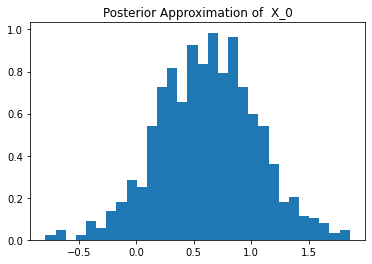

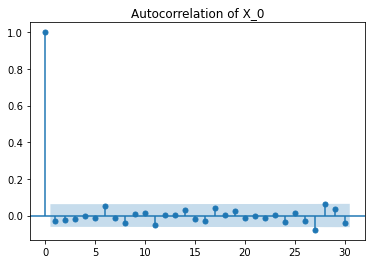

Figure(432x288)


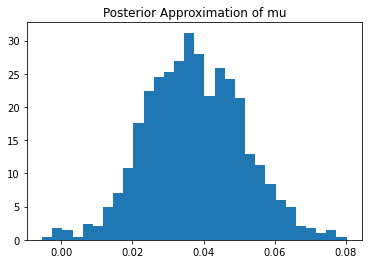

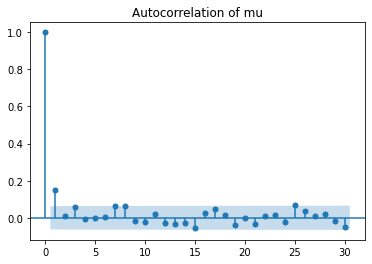

Figure(432x288)


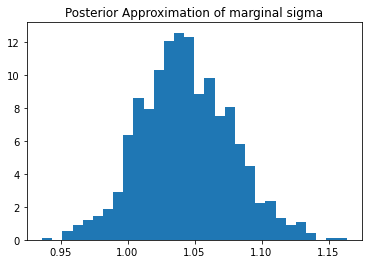

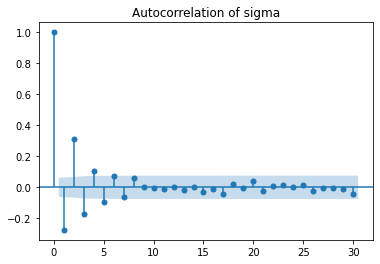

Figure(432x288)


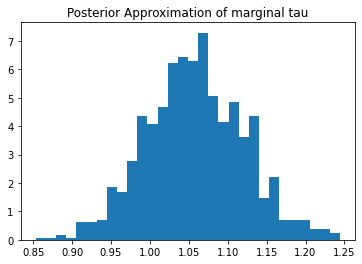

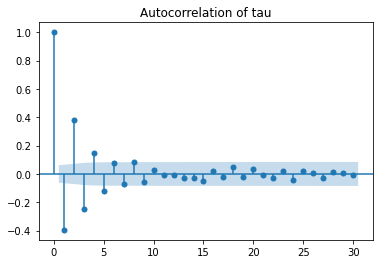

In [89]:
#Plot posterior of X_0
sampled_x0 = x_Gibbs[:,0]

#Plot distribution sampled by algorithm
plt.hist(sampled_x0, bins=30, density=True, stacked=True)
plt.title('Posterior Approximation of  X_0')
print(plot_acf(sampled_x0, title = 'Autocorrelation of X_0'))
plt.show()


#Plot posterior of mu
sampled_mu = theta_Gibss[:,0]

#Plot distribution sampled by algorithm
plt.hist(sampled_mu, bins=30, density=True, stacked=True)
plt.title('Posterior Approximation of mu')
print(plot_acf(sampled_mu, title = 'Autocorrelation of mu'))
plt.show()


#Plot posterior of sigma
sampled_sigma = theta_Gibss[:,1]

#Plot distribution sampled by algorithm
plt.hist(sampled_sigma, bins=30, density=True, stacked=True)
plt.title('Posterior Approximation of marginal sigma')
print(plot_acf(sampled_sigma, title = 'Autocorrelation of sigma'))
plt.show()

#Plot posterior of tau
sampled_tau = theta_Gibss[:,2]

#Plot distribution sampled by algorithm
plt.hist(sampled_tau, bins=30, density=True, stacked=True)
plt.title('Posterior Approximation of marginal tau')
print(plot_acf(sampled_tau, title = 'Autocorrelation of tau'))
plt.show()


Bigger blocks Gibbs

In [80]:
x_Gibbs2, mu_Gibbs, sigma_Gibbs, tau_Gibbs = block_Gibbs_ex3(synth_y, synth_x, np.asarray([5]*1000), np.asarray([0, 1,1]),0.1, 0.1, 0.1, 1000)


100%|██████████| 999/999 [04:14<00:00,  3.93it/s]


Figure(432x288)


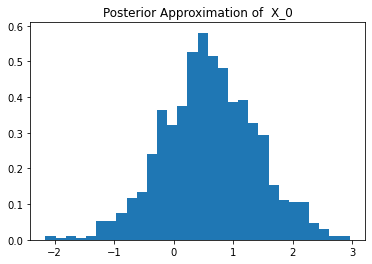

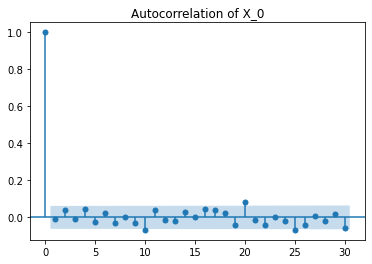

Figure(432x288)


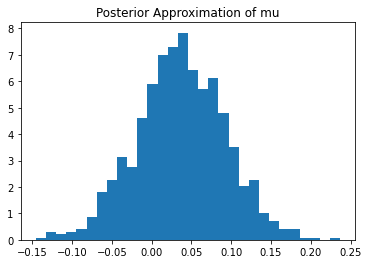

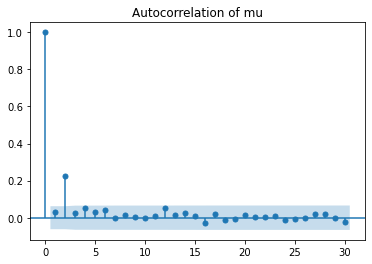

Figure(432x288)


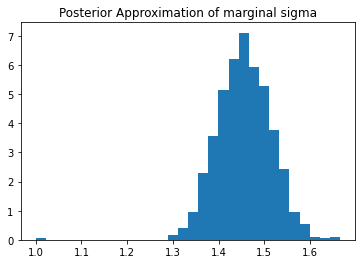

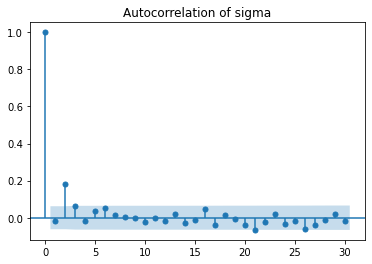

Figure(432x288)


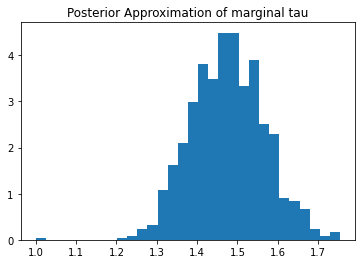

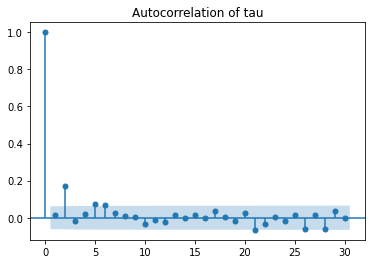

In [90]:
#Plot posterior of X_0
sampled_x0 = x_Gibbs2[:,0]

#Plot distribution sampled by algorithm
plt.hist(sampled_x0, bins=30, density=True, stacked=True)
plt.title('Posterior Approximation of  X_0')
print(plot_acf(sampled_x0, title = 'Autocorrelation of X_0'))
plt.show()

#Plot posterior of mu

#Plot distribution sampled by algorithm
plt.hist(mu_Gibbs, bins=30, density=True, stacked=True)
plt.title('Posterior Approximation of mu')
print(plot_acf(mu_Gibbs, title = 'Autocorrelation of mu'))
plt.show()

#Plot posterior of sigma
#Plot distribution sampled by algorithm
plt.hist(sigma_Gibbs, bins=30, density=True, stacked=True)
plt.title('Posterior Approximation of marginal sigma')
print(plot_acf(sigma_Gibbs, title = 'Autocorrelation of sigma'))
plt.show()


#Plot posterior of tau

#Plot distribution sampled by algorithm
plt.hist(tau_Gibbs, bins=30, density=True, stacked=True)
plt.title('Posterior Approximation of marginal tau')
print(plot_acf(tau_Gibbs, title = 'Autocorrelation of tau'))
plt.show()


We can see that there is not a great change in the results, nor the number of iterations needed, which is expected. One one hand, it is expected since the difference is very small in terms of how many blocks are used in each algorithm. On the other hand, we have closed formulas for the distribution of each of the blocks in both cases,  so the sampling steps are not very costly.